# Assignment 4 - Vanilla RNN

In [1]:
from __future__ import unicode_literals, print_function, division
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from scipy import sparse

from io import open
import unicodedata
import string, time, random
from itertools import count

Automatically created module for IPython interactive environment


## Exercise 1: Read in the data

In [2]:
book_fname = 'Data/goblet_book.txt'
book_data = open(book_fname, encoding='utf-8').read()

In [3]:
print(len(book_data))

1107542


In [4]:
book_chars = ''.join(sorted({l for word in book_data for l in word}))

In [15]:
print(len(book_chars))
print(book_chars)

80
	
 !"'(),-./01234679:;?ABCDEFGHIJKLMNOPQRSTUVWXYZ^_abcdefghijklmnopqrstuvwxyz}ü•


In [12]:
print(book_chars.find('A'))

23


In [9]:
# Dictionary with each key is a character and value is its position in book_chars (1,80)
char2int = dict(zip(book_chars, count(0)))
print(char2int)

{'\t': 0, '\n': 1, ' ': 2, '!': 3, '"': 4, "'": 5, '(': 6, ')': 7, ',': 8, '-': 9, '.': 10, '/': 11, '0': 12, '1': 13, '2': 14, '3': 15, '4': 16, '6': 17, '7': 18, '9': 19, ':': 20, ';': 21, '?': 22, 'A': 23, 'B': 24, 'C': 25, 'D': 26, 'E': 27, 'F': 28, 'G': 29, 'H': 30, 'I': 31, 'J': 32, 'K': 33, 'L': 34, 'M': 35, 'N': 36, 'O': 37, 'P': 38, 'Q': 39, 'R': 40, 'S': 41, 'T': 42, 'U': 43, 'V': 44, 'W': 45, 'X': 46, 'Y': 47, 'Z': 48, '^': 49, '_': 50, 'a': 51, 'b': 52, 'c': 53, 'd': 54, 'e': 55, 'f': 56, 'g': 57, 'h': 58, 'i': 59, 'j': 60, 'k': 61, 'l': 62, 'm': 63, 'n': 64, 'o': 65, 'p': 66, 'q': 67, 'r': 68, 's': 69, 't': 70, 'u': 71, 'v': 72, 'w': 73, 'x': 74, 'y': 75, 'z': 76, '}': 77, 'ü': 78, '•': 79}


In [21]:
# Example of using char2int to encode a string
text = 'Nga'
indexes = [
  letter_mapping[letter] for letter in text 
  if letter in char2int
]
print(indexes)

[37, 58, 52]


In [10]:
# Dictionary with each key is a number in (1,80) and value is corresponding character
int2char = {v: k for k, v in char2int.items()}
print(int2char)

{0: '\t', 1: '\n', 2: ' ', 3: '!', 4: '"', 5: "'", 6: '(', 7: ')', 8: ',', 9: '-', 10: '.', 11: '/', 12: '0', 13: '1', 14: '2', 15: '3', 16: '4', 17: '6', 18: '7', 19: '9', 20: ':', 21: ';', 22: '?', 23: 'A', 24: 'B', 25: 'C', 26: 'D', 27: 'E', 28: 'F', 29: 'G', 30: 'H', 31: 'I', 32: 'J', 33: 'K', 34: 'L', 35: 'M', 36: 'N', 37: 'O', 38: 'P', 39: 'Q', 40: 'R', 41: 'S', 42: 'T', 43: 'U', 44: 'V', 45: 'W', 46: 'X', 47: 'Y', 48: 'Z', 49: '^', 50: '_', 51: 'a', 52: 'b', 53: 'c', 54: 'd', 55: 'e', 56: 'f', 57: 'g', 58: 'h', 59: 'i', 60: 'j', 61: 'k', 62: 'l', 63: 'm', 64: 'n', 65: 'o', 66: 'p', 67: 'q', 68: 'r', 69: 's', 70: 't', 71: 'u', 72: 'v', 73: 'w', 74: 'x', 75: 'y', 76: 'z', 77: '}', 78: 'ü', 79: '•'}


In [26]:
# Another way to read in data
data = open(book_fname, 'r').read() # should be simple plain text file
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print('data has %d characters, %d unique.' % (data_size, vocab_size))
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }
print(chars)

data has 1107542 characters, 80 unique.


In [5]:
def one_hot_matrix(chars, vocab_size):
    n = len(chars)
    x_one_hot = np.zeros((vocab_size,n))    
    x_one_hot[[char2int[ch] for ch in chars], range(n)] = 1
    return x_one_hot

def plotResults(x,y,name='loss',save_name=None):
    fig = plt.figure()
    plt.plot(x,y)
    plt.xlabel('n_update')
    plt.ylabel(name)
    if save_name is not None:
        fig.savefig('Figures/'+name+'_'+save_name+'.pdf')
    plt.show()

## Exercise 2: Set hyper-parameters and initialize the RNN’s parameters

In [6]:
class RNN(object):
    """
    A Vanilla Recurrent neural network.
    """

    def __init__(self, vocab_size=80 ,hidden_dim=100, 
                 weight_scale=0.01, dtype=np.float32,):
        """
        Initialize a new network.

        Inputs:
        - vocab_size: the total letters of the input
        - hidden_dim: Number of units to use in hidden layer
        - weight_scale: Scalar giving standard deviation for random initialization
          of weights.
        - dtype: numpy datatype to use for computation.
        """
        self.h0 = np.zeros((hidden_dim , 1))
        
        self.params = {}
        self.dtype = dtype
        
        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim
        self.weight_scale = weight_scale
                      
        self.init_sets()
    
    
    def init_sets(self):
        """
        Initialize model parameters
        """
        # The biases
        self.params['b'] = np.zeros((self.hidden_dim,1))  # m x 1
        self.params['c'] = np.zeros((self.vocab_size,1))  # K x 1
           
        # The weights
        self.params['U'] = self.weight_scale*np.random.randn(self.hidden_dim,self.vocab_size)  # m x K
        self.params['W'] = self.weight_scale*np.random.randn(self.hidden_dim,self.hidden_dim)  # m x m
        self.params['V'] = self.weight_scale*np.random.randn(self.vocab_size,self.hidden_dim)  # K x m

        for k, v in self.params.items():
            self.params[k] = v.astype(self.dtype)
        
    
    ## Exercise 3: Synthesize text from your randomly initialized RNN
    def sample(self, x0, n):
        """
        - h0: m x 1 vector of hidden state at time 0 
        - x0: K x 1 first input vector
        - n: the length of the sequence to generate
        """
        U, W, V = self.params['U'], self.params['W'], self.params['V']
        b, c = self.params['b'], self.params['c']
        
        xnext = np.zeros((len(x0),n))
        h, x = self.h0.copy(), x0
        for i in range(n):
            h = np.tanh(np.dot(W,h) + np.dot(U,x) + b)  # m x 1
            s = np.dot(V,h) + c  # K x 1
            p = np.exp(s-np.max(s))/np.sum(np.exp(s-np.max(s)))  # K x 1
            # find next x
            au = np.random.rand()
            ix = np.argwhere(np.cumsum(p)>au)[0]
            xnext[ix,i] = 1
            x = xnext[:,[i]]
        
        return xnext

    def loss(self, X, Y, mode='train'):
        """
        Evaluate loss and gradient for recurrent neural network.
        - y=None: for testing
        - h0 is mx1 array of initial hidden state
        """
        X = X.astype(self.dtype)
        Y = Y.astype(self.dtype)

        U, W, V = self.params['U'], self.params['W'], self.params['V']
        b, c = self.params['b'], self.params['c']
        
        _,N = X.shape
        
        # Forward pass
        ht, st, pt = {}, {}, {}
        ht[-1] = self.h0.copy()
        
        loss = 0
        for t in range(N):
            ht[t] = np.tanh(np.dot(W,ht[t-1]) + np.dot(U,X[:,[t]]) + b)  # m x 1
            st[t] = np.dot(V,ht[t]) + c  # K x 1
            pt[t] = np.exp(st[t]-np.max(st[t]))/np.sum(np.exp(st[t]-np.max(st[t])))
            loss += -np.log(np.dot(Y[:,[t]].T,pt[t]))
            
        if mode=='test':
            return loss
        
        # Backward pass
        grads = {}
        dU, dW, dV = np.zeros_like(U), np.zeros_like(W), np.zeros_like(V)
        db, dc = np.zeros_like(b), np.zeros_like(c)
        dh_next = np.zeros_like(self.h0)
        for t in reversed(range(N)):
            dst = pt[t] - Y[:,[t]]
            dV += np.dot(dst,ht[t].T)
            dc = dc + dst
            dht = np.dot(V.T,dst) + dh_next
            dat = dht*(1-ht[t]*ht[t])  # m x 1
            db = db + dat
            dU += np.dot(dat,X[:,[t]].T)  # m x K
            dW += np.dot(dat,ht[t-1].T)  # m x m
            dh_next = np.dot(W.T,dat)
               
        grads['U'], grads['W'], grads['V'] = dU, dW, dV
        grads['b'], grads['c'] = db, dc
        
        for k,v in grads.items():
            np.clip(v,-5,5,out=v)
        
        self.h0 = ht[N-1].copy()
        return loss, grads

In [8]:
def checkGradients(X,Y,h=1e-4):
    eps = 1e-30
    err = 1e-6
    
    net = RNN(hidden_dim=5)
    _,grads_a = net.loss(X,Y)
    
    params = net.params
    grads_n = {}    
    for key,param in params.items():
        grads_n[key] = np.zeros_like(param)
        total_error = 0
        for i in range(param.size):
            param.flat[i] += h
            l1 = net.loss(X,Y,mode='test')
            param.flat[i] -= 2*h
            l2 = net.loss(X,Y,mode='test')
            param.flat[i] += h
            grads_n[key].flat[i] = (l1-l2)/(2*h)
        # Relative error
        error = np.abs(grads_a[key]-grads_n[key])/np.maximum(eps,np.abs(grads_a[key])+np.abs(grads_n[key]))
        total_error += np.sum(error>err)
        max_error = np.max(error)
        print('The number of errors (relative error > 1e-6) of {}: {}'.format(key, total_error))
        print('The maximum of relative error of {}: {}'.format(key, max_error))   

## Exercise 3: Synthesize text from your randomly initialized RNN

In [93]:
# Create input
x0 = np.zeros((80,1))
x0[char2int['N']] = 1
h0 = np.zeros((100,1))

In [94]:
net = RNN()
xnext = net.sample(x0,200)

In [81]:
print(xnext.shape)

(80, 200)


In [95]:
print(np.argmax(xnext, axis=0))
text = ''.join(int2char[ix] for ix in np.argmax(xnext, axis=0))
print(text)

[68 18 24 50  5 13 13  0 39 63 42  6 38 28 49 68 35 69 58 45 22 31 46 25
 20 42  1 18 54 74 16 39 73 29 40  6 21 18  1 19 49 53 74 60 43 56 59 31
 14 53 37 43 69 29 42 36 68 79  2  3 16  9 23  0 40 24 44  5 75 27 53 62
 32 45 26 74 38 32 22 20  2 53 38  1 71 63  3 46 41 63  9 61 73  8 79 50
 27 52 78 57 12  3 49 35 35 15 57 66 41 14 39 37 17 23 25 58 48 55 36 42
 56 54  0 54 61 78 66 17 65 67 36 34 27  7 22 43 32 53 23 38 24 30  7 58
 53 77 10 33 14 36 38 68 17 35 60  9  0 54 27  4 74 51 65 68 38 57 11 24
 31  9 66  5 51 74 15 37 71 49 46 45 23 53 76 33 13 64 54 52 17 61 23 52
 52 72 74 10 49  1 11 43]
r7B_'11	QmT(PF^rMshW?IXC:T
7dx4QwGR(;7
9^cxjUfiI2cOUsGTNr• !4-A	RBV'yEclJWDxPJ?: cP
um!XSm-kw,•_Ebüg0!^MM3gpS2QO6AChZeNTfd	dküp6oqNLE)?UJcAPBH)hc}.K2NPr6Mj-	dE"xaorPg/BI-p'ax3Ou^XWAczK1ndb6kAbbvx.^
/U


## Exercise 4: Implement the forward & backward pass of back-prop

In [132]:
X_chars = book_data[:25]
Y_chars = book_data[1:26]

In [133]:
print(X_chars)
print(Y_chars)

HARRY POTTER AND THE GOBL
ARRY POTTER AND THE GOBLE


In [134]:
X = one_hot_matrix(X_chars)
Y = one_hot_matrix(Y_chars)

In [135]:
print(X.shape, Y.shape)

(80, 25) (80, 25)


In [152]:
h0 = np.zeros((5,1))
checkGradients(X,Y,h0,h=1e-4)

The number of errors (relative error > 1e-6) of b: 0
The maximum of relative error of b: 2.1481670643567495e-08
The number of errors (relative error > 1e-6) of c: 0
The maximum of relative error of c: 2.8953546415392706e-08
The number of errors (relative error > 1e-6) of U: 0
The maximum of relative error of U: 8.838543408273836e-07
The number of errors (relative error > 1e-6) of W: 7
The maximum of relative error of W: 2.490667611709796e-05
The number of errors (relative error > 1e-6) of V: 15
The maximum of relative error of V: 1.710842866486928e-06


## Exercise 5: Train RNN using AdaGrad

In [7]:
class Model(object):
    
    def __init__(self, model, data, **kwargs):
        
        self.model = model
        self.data = data

        # Unpack keyword arguments
        self.optimizer = kwargs.pop('optimizer', 'adagrad')
        self.optim_config = kwargs.pop('optim_config', {})
        self.seq_length = kwargs.pop('seq_length', 25)
        self.num_epochs = kwargs.pop('num_epochs', 10)

        self.print_every = kwargs.pop('print_every', 100)
        self.verbose = kwargs.pop('verbose', True)

        # Throw an error if there are extra keyword arguments
        if len(kwargs) > 0:
            extra = ', '.join('"%s"' % k for k in list(kwargs.keys()))
            raise ValueError('Unrecognized arguments %s' % extra)

        self._reset()
    
    
    def _reset(self):
        """
        Set up some book-keeping variables for optimization. Don't call this
        manually.
        """
        # Set up some variables for book-keeping
        self.best_loss = 0
        self.best_params = {}
        self.loss_history = []
        self.smooth_loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []

        # Make a deep copy of the optim_config for each parameter
        self.optim_configs = {}
        for p in self.model.params:
            d = {k: v for k, v in self.optim_config.items()}
            self.optim_configs[p] = d
    
    
    def train(self):
        """
        Run optimization to train the model.
        """
        num_train = len(self.data)
        hidden_dim = self.model.hidden_dim
        vocab_size = self.model.vocab_size
        seq_length = self.seq_length
        iterations_per_epoch = max(num_train // seq_length, 1)
        num_iterations = self.num_epochs * iterations_per_epoch
        
        smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0
        self.best_loss = smooth_loss
        pos = 0
        for t in range(num_iterations):          
            if pos+seq_length+1>=len(self.data) or t==0:
                self.model.h0 = np.zeros((hidden_dim,1)) # reset h0
                pos = 0
            # preparing data to train
            X_chars = self.data[pos:pos+seq_length]
            Y_chars = self.data[pos+1:pos+seq_length+1]
            X = one_hot_matrix(X_chars, vocab_size)
            Y = one_hot_matrix(Y_chars, vocab_size)
            # Print sample from the model now and then
            if self.verbose and t % self.print_every == 0: 
                sample_ix = self.model.sample(X[:,[0]], 200)
                txt = ''.join(int2char[ix] for ix in np.argmax(sample_ix, axis=0))
                print('----\n %s \n----' % (txt, ))
            
            # Compute loss and gradient
            loss, grads = self.model.loss(X, Y)
            self.loss_history.append(loss)
            smooth_loss = smooth_loss * 0.999 + loss * 0.001 
            self.smooth_loss_history.append(smooth_loss)
            # Print training smooth_loss and sample from the model now and then
            if self.verbose and t % self.print_every == 0: 
                print('(Iteration %d / %d) loss: %f' % (
                       t + 1, num_iterations, smooth_loss))
            
            # Perform a parameter update
            for p, w in self.model.params.items():
                dw = grads[p]
                config = self.optim_configs[p]
                next_w, next_config = globals()[self.optimizer](w, dw, config)
                self.model.params[p] = next_w
                self.optim_configs[p] = next_config
                
            pos += seq_length
            
            # Check train and val accuracy on the first iteration, the last
            # iteration, and at the end of each epoch.
            epoch_end = (t + 1) % iterations_per_epoch == 0
            first_it = (t == 0)
            last_it = (t == num_iterations - 1)
            if first_it or last_it or epoch_end:
                # Keep track of the best model
                if smooth_loss < self.best_loss:
                    self.best_loss = smooth_loss
                    self.best_params = {}
                    for k, v in self.model.params.items():
                        self.best_params[k] = v.copy()

        # At the end of training swap the best params into the model
        self.model.params = self.best_params



def adagrad(w, dw, config=None):
    """
    Performs a variant of stochastic gradient descent, AdaGrad.

    config format:
    - learning_rate: Scalar learning rate.
    """
    if config is None: config = {}
    config.setdefault('learning_rate', 0.1)
    config.setdefault('epsilon', 1e-8)
    config.setdefault('m', np.zeros_like(w))
 
    config['m'] += dw**2
    next_w = w - config['learning_rate']*dw/(np.sqrt(config['m'])+config['epsilon'])

    return next_w, config

In [11]:
net = RNN()
model = Model(net, book_data,
              num_epochs=10,
              optimizer='adagrad',
              optim_config={
                  'learning_rate': 0.1},
              verbose=True, print_every=10000)

tic = time.time()
model.train()
toc = time.time()
print('Execution time: ',toc-tic)

----
 x1F4tMNVRA;hQdcf
us;2eQev"?eyq_R^}XurFOH?;OKq 1j1H
•XjwW}(msV}vwpBEq•'d4s"o.0rRMWhzrEH^ W•üTlCahBuXu,,RF,TqO;wN
EetOCAiHJP4L0xdPWBaf_J^SR;ic.EC};fPh"(Rz}^Y4?pq.Vd6L4e'zry	JXWFP7kZd2SmvjbcpCK/yteZ'Q!X• 
----
(Iteration 1 / 443010) loss: 109.550669
----
 unkeallgem pullerry gore harol it.
 Ek ofmooniyh. thas at withcee of thhe hus  thly wrraplicht a mis,"?"  Amen ofed werim beinge gtard ealle warcret ofly hise carire; he Dugoferk do mames besandny, pi 
----
(Iteration 10001 / 443010) loss: 52.856775
----
 egt, a conke S heon, in the gone himain it us the ters fored at ham, burht urnthouse?"  er. Caiced achr.  Thearing awing.  Harry a and thead hingep let-werdwing it Ha rooms thick upporent anf, youp wh 
----
(Iteration 20001 / 443010) loss: 49.432265
----
 ese. . . perbious to com sayed orming a axtore hom pidly anne ewends expice of Hermies - rowor had agor ach as flilce thar on," roses. . . . . . Wowen steaked, plopberdre all to lote con list caure eS 
----
(Iteration 30001 / 443

----
 ed, dray thim knastome the to jooch Cedsimisins.  Fher?"
"Chaired of the could at by the pleicke theres, doorely, whark been and crosppedning to that it.  she and sheat the your een should Snakeyen. H 
----
(Iteration 320001 / 443010) loss: 42.402553
----
 ic a the stantely, as by ressicinged, plawed to Hagik to, spah his welting to wink, the door down furies and you'le wain.  Stours.  Dum!" said Rou novery.
"Loomponce fore them - Olly rowe.  "I lealg a 
----
(Iteration 330001 / 443010) loss: 42.323424
----
 ffpistngering ountries.
The enton?"
"
HHowShover to the Henther lookiny.  We its," said at Werent," said Hermeeportly.
"Where smomblewoldome sik was but a mastch and the strets was hap en something at 
----
(Iteration 340001 / 443010) loss: 42.766548
----
 ken the Jorkended's her ho rose, Vag thire you andwice wroag Take sard Cumpill.  As it all could was cark, Harry shand simery, - and was then in the sharter rafirainst the offer with a banted and What 
----
(Iteration 35000

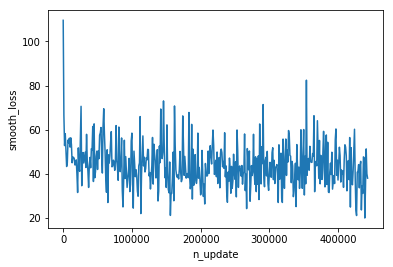

In [12]:
n_updates = len(book_data)//25*model.num_epochs
x = np.arange(0,n_updates,1000)
loss = np.squeeze(np.array(model.loss_history))[x]
plotResults(x,loss,name='smooth_loss',save_name='10_epochs_1000')

In [13]:
print(model.best_loss)
x0 = one_hot_matrix(book_data[0], model.model.vocab_size)

xnext = model.model.sample(x0,1000)
text = ''.join(int2char[ix] for ix in np.argmax(xnext, axis=0))
print(text)

[[40.52186834]]
ard, slel.  Sigwive the.  Lik very But Dumbledoref, and tormated nold himpeen," Harry son't laugher his to to anvicks.  "He door me houghor, "Thated them, but he's it orfath at it her sa tow Harry, "Son."  "Davenghed to in the a been for to Harry," he the comporing to reastle eybligh but beserived on the golles not her stormail offied.  "Thet be would's cleatoms on stlace could tain."
That was take got wint as the touther trees it and the end had wiel, Harry.  They ever to up aboit usted to his that Dup, wherily stay frowm the denge fet whose had Imbyges.  "He were know. Dumbledore time ling with," said yed up orme've curming to that
"Now.  "Moviet a girs," Iad gooked a whilp had the scraut not and shag sike Harry.  Harry dims told.  "Soled Boway had the sally serted Dood; aront beandy apill theudgen the rowin info the tothof.  He toun ever tiks in the troulkstatifilct and Geoble that Dumbledore said, and Dumbledorrst.  Exs byemw.
"Dopters.  His drawing hern't fore staa